In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

data = np.load('data/tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)



(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


[[-9.3054223e-01  1.1707554e-01 -3.4696460e-01 -1.3986591e+00]
 [-3.6618456e-01 -2.9751042e-01  8.8170075e-01  3.5542498e+00]
 [ 7.4505806e-09  9.4751304e-01  3.1971723e-01  1.2888215e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


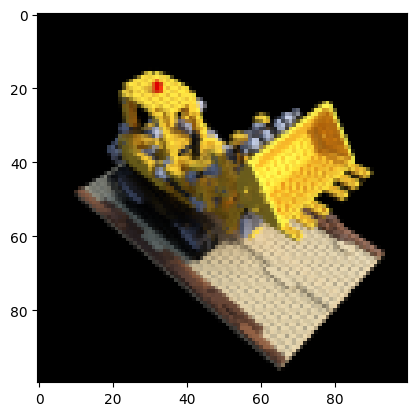

In [2]:
testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]
print(poses[1])
plt.imshow(testimg)
plt.show()

In [3]:
def gamma(p, L=6):
    res = []
    for i in range(L):
        res.append(torch.sin(2**i * p))
        res.append(torch.cos(2**i * p))
    return torch.concat(res, -1)

def get_rays(W, H, focal, cam_pose):
    cam_pose = torch.tensor(cam_pose)
    x, y = torch.meshgrid(torch.range(0,W-1), torch.range(0,H-1), indexing="xy")
    dirs = torch.stack(((x-W*0.5)/focal, (H*0.5-y)/focal, -torch.ones_like(x)), -1) 
    dirs = dirs[..., np.newaxis, :]
    dirs = torch.sum(dirs*cam_pose[:3, :3], -1)
    origins = torch.broadcast_to(cam_pose[:3, -1], dirs.size())
    return origins.to(DEVICE), dirs.to(DEVICE)

def C(r):
    pass

def render(net, rays_o, rays_d, near, far, N_samples, randomize_samples=False):
    # sample N points from ray along midpoint o and direction d using uniform z values from near to far
    z = torch.linspace(near, far, N_samples).to(DEVICE)

    # add a random uniform distribution to the sampled points during training
    if randomize_samples:
        z  = z + torch.rand(list(rays_o.shape[:-1]) + [N_samples]).to(DEVICE) * (far-near)/N_samples

    pts = rays_o[..., None, :] + rays_d[..., None, :] * z[..., :, None]

    # apply positional encoding function `gamma` to augment the points
    pts_processed = torch.reshape(pts, [-1, 3])
    pts_processed = gamma(pts_processed)

    # split processed poins into batches
    batch = 32*1024
    pts_processed = torch.split(pts_processed, batch)
    
    # run processed points through neural network
    out = torch.concat([net(pts_processed[i]) for i in range(len(pts_processed))])
    out = torch.reshape(out, list(pts.shape[:-1]) + [4])

    # sigma (opacity) = 4th row of output rectified with ReLU
    # rgb (color) = 1st-3rd row of output rectified with Sigmoid
    sigma = torch.nn.ReLU()(out[..., 3])
    rgb = torch.nn.Sigmoid()(out[...,:3])
    # print(z[...,:1].shape)
    dists = torch.concat([z[..., 1:] - z[..., :-1], torch.broadcast_to(torch.tensor([1e10]).to(DEVICE), z[...,:1].shape)], -1)
    alpha = 1.-torch.exp(-sigma * dists)  
    weights = alpha * torch.cumprod(1.-alpha + 1e-10, -1)

    rgb_map = torch.sum(weights[...,None] * rgb, -2) 
    depth_map = torch.sum(weights * z, -1) 
    acc_map = torch.sum(weights, -1)

    return rgb_map, depth_map, acc_map

class NeRF(nn.Module):
    def __init__(self):
        super(NeRF, self).__init__()

        # 4 dense layers of size 256 with ReLU
        self.first = nn.Sequential(
            nn.Linear(36, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU()
        )

        # self.second = nn.Linear(256, 256)
        # one dense layer concatenated with lambda(x) with ReLU
        # three dense layers of size 256 with ReLU
        self.second = nn.Sequential(
            nn.Linear(292, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.Linear(256, 4)
        )
        # one layer of size 4 with no activation

        self.net = nn.Sequential()

    def forward(self, x):
        y = self.first(x)
        y = torch.concat([x, y], -1)
        y = self.second(y)
        return y
        

def train(model, epochs = 1000, N_samples = 64, i_plot = 50, lr=5e-4):
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = torch.nn.MSELoss(reduction='sum')

    for i in range(epochs+1):
        img_i = np.random.randint(images.shape[0])
        target = images[img_i]
        pose = poses[img_i]
        rays_o, rays_d = get_rays(H, W, focal, pose)
        optim.zero_grad()
        rgb, depth, acc = render(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, randomize_samples=True)
        loss = loss_fn(rgb, torch.tensor(target).to(DEVICE))
        loss.backward()
        optim.step()


        if i % i_plot == 0:
            rgb, depth, acc = test(model, testpose)
            loss = loss_fn(rgb, torch.tensor(testimg).to(DEVICE))
            print("Epoch {0}/{1} loss: {2}".format(i, epochs, loss))
            plt.imshow(rgb.cpu().clone().detach().numpy())
            plt.show()

def test(model, pose):
    rays_o, rays_d = get_rays(H, W, focal, pose)
    rgb, depth, acc = render(model, rays_o, rays_d, near=2., far=6., N_samples=64)

    return rgb, depth, acc


/tmp/ipykernel_3716/2441410908.py:10: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x, y = torch.meshgrid(torch.range(0,W-1), torch.range(0,H-1), indexing="xy")


Epoch 0/1000 loss: 2553.06982421875


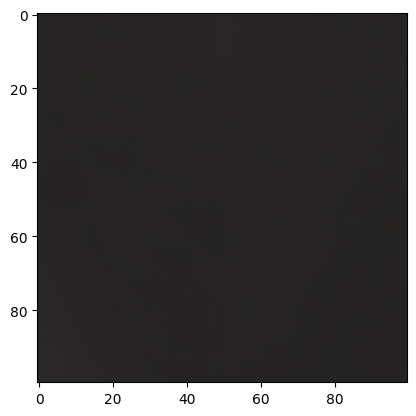

Epoch 50/1000 loss: 1291.043701171875


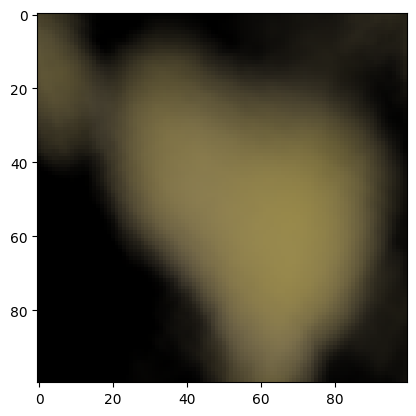

Epoch 100/1000 loss: 1093.982421875


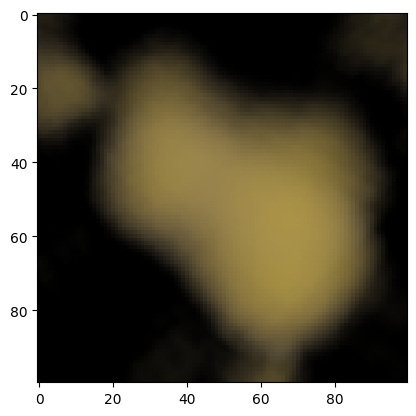

Epoch 150/1000 loss: 1135.921142578125


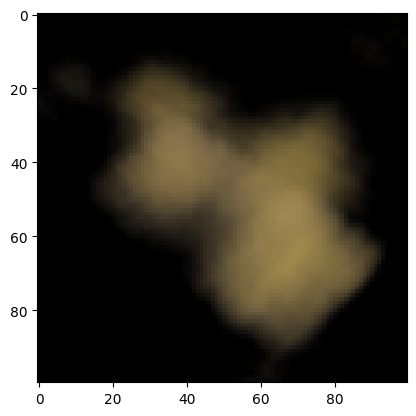

Epoch 200/1000 loss: 1015.4674072265625


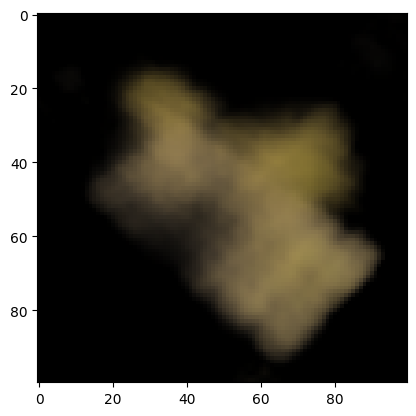

Epoch 250/1000 loss: 503.66058349609375


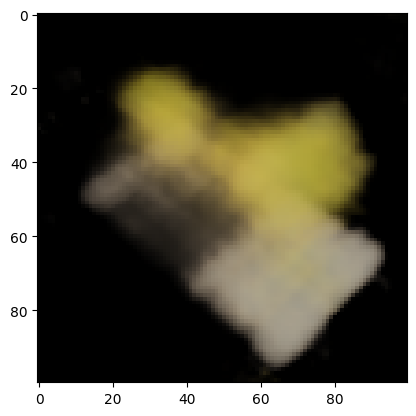

Epoch 300/1000 loss: 724.338623046875


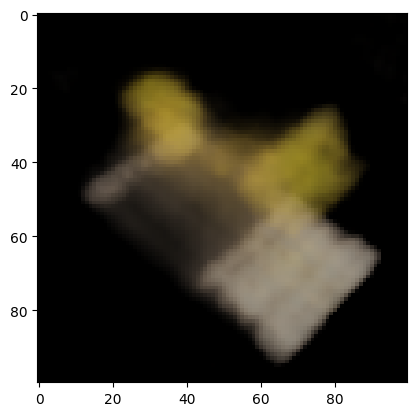

Epoch 350/1000 loss: 485.33367919921875


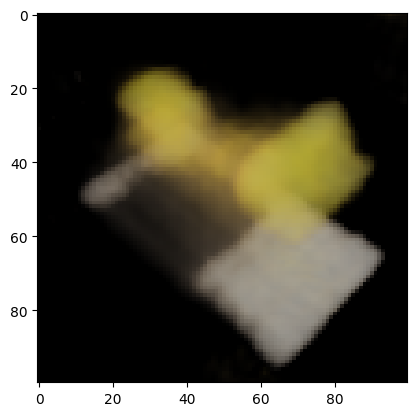

Epoch 400/1000 loss: 474.8161926269531


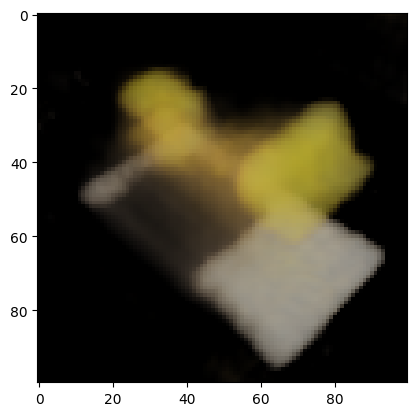

Epoch 450/1000 loss: 482.72698974609375


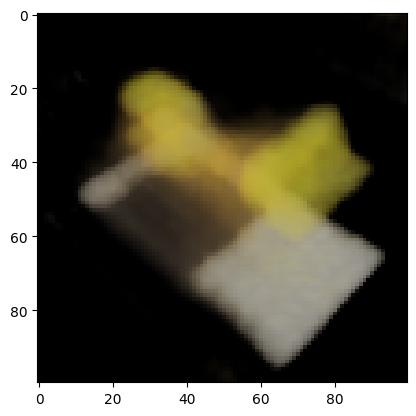

Epoch 500/1000 loss: 502.65936279296875


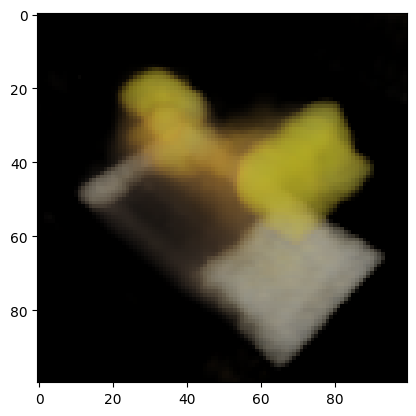

Epoch 550/1000 loss: 454.48712158203125


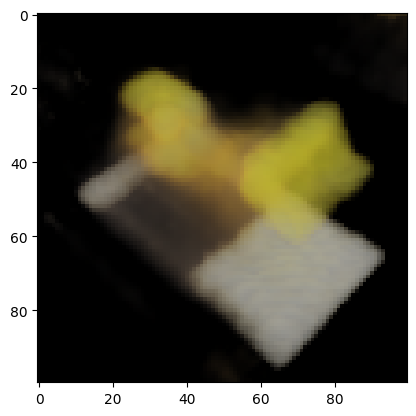

Epoch 600/1000 loss: 443.01434326171875


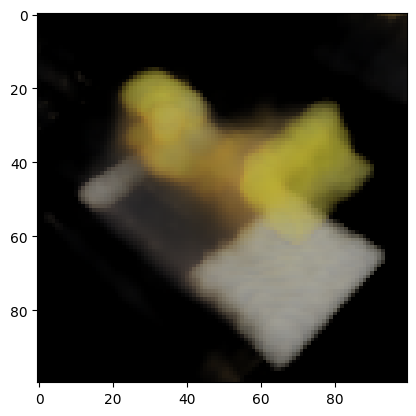

Epoch 650/1000 loss: 410.0180969238281


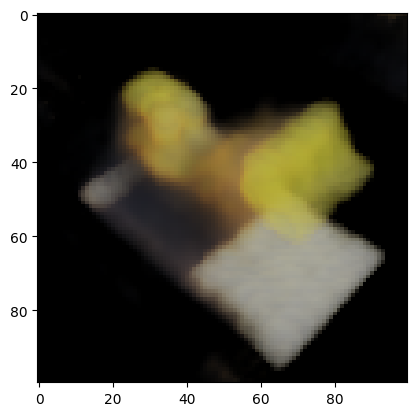

Epoch 700/1000 loss: 445.9744873046875


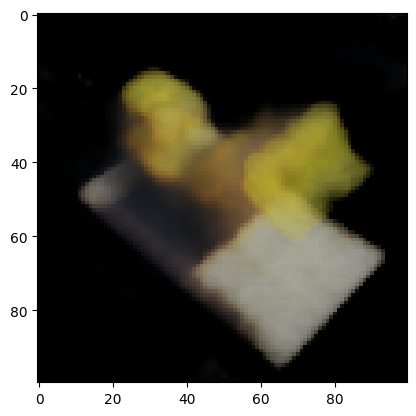

Epoch 750/1000 loss: 406.0562744140625


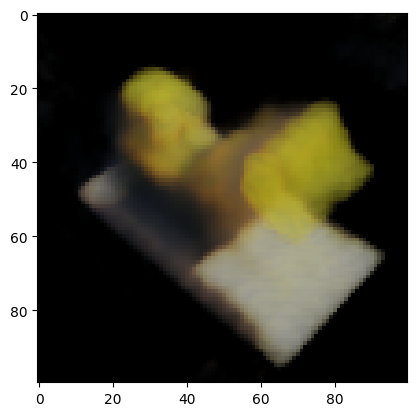

Epoch 800/1000 loss: 425.6466064453125


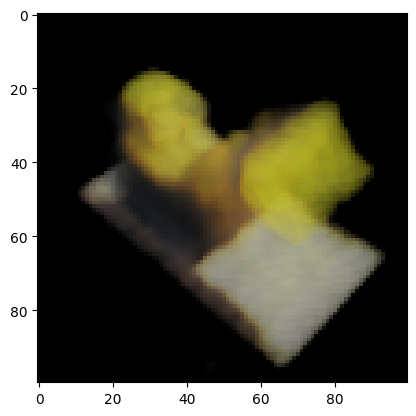

Epoch 850/1000 loss: 371.08648681640625


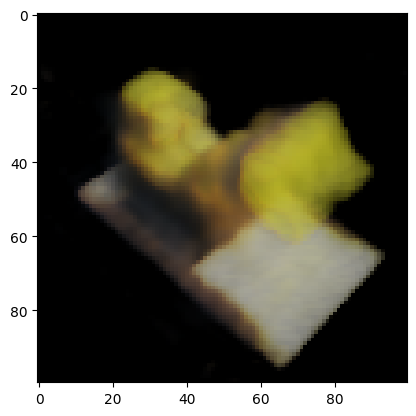

Epoch 900/1000 loss: 343.7082824707031


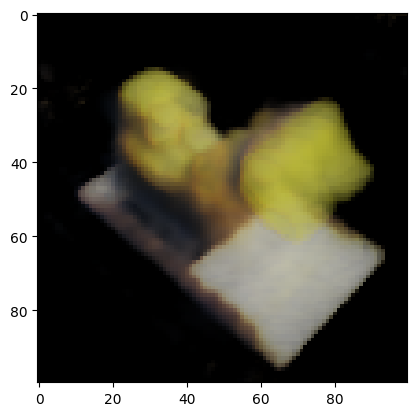

Epoch 950/1000 loss: 342.55194091796875


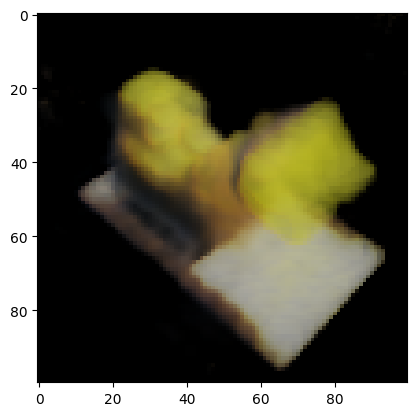

Epoch 1000/1000 loss: 339.468505859375


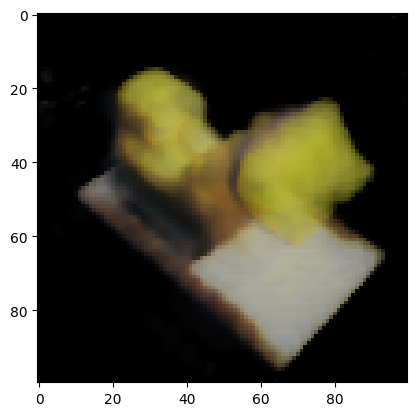

In [4]:
pose = poses[0]
rays_o, rays_d = get_rays(W, H, focal, pose)
net = NeRF()
net.to(DEVICE)

train(net)

/tmp/ipykernel_3716/2441410908.py:10: UserWarning: torch.range is deprecated and will be removed in a future release because its behavior is inconsistent with Python's range builtin. Instead, use torch.arange, which produces values in [start, end).
  x, y = torch.meshgrid(torch.range(0,W-1), torch.range(0,H-1), indexing="xy")


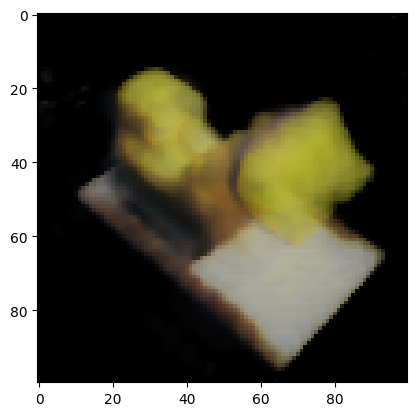

In [5]:
rgb, depth, acc = test(net, testpose)
plt.imshow(rgb.cpu().clone().detach().numpy())
plt.show()